<h1><center>Numerical Methods for Pricing Options with Transaction Costs </center></h1>

<center><b>Abstract</b></center>
<center> Black-Scholes option pricing theory rests on an arbitrage argument where it should be possible to adjust the portfolio continuously. In presence of transaction costs (as it happens in real markets) this assumption leads to a problematic situation. Indeed, diffusion process have infinite variation and a continuous trading would be ruinously expensive. Formally, the arbitrage argument will no longer be valid because replicating the portfolio will be infinitely costly so a discrete revision of Black-Scholes will be needed. In this work we examine a simple model where the costs behave as a non-increasing linear function and using finite difference methods we price the option. </center>

### Define Stock class and European Option class.
##### Definition of a stock: 
A stock (also known as equity) is a security that represents the ownership of a fraction of a corporation. This entitles the owner of the stock to a proportion of the corporation's assets and profits equal to how much stock they own. 
##### Definition of an european option: 
An European option is a contract that allows a buyer the right to buy (call) or sell (put) an underlying asset or financial instrument at a specified strike price $K$ on a specified expiration date $T$. The option can be purchased for a price called the premium, at time $t < T$.

In [4]:
class Stock(object):
    """Stock class contains all the information about the financial instrument.
    
    Parameters:
    -----------
    
    S0: float
        Stands for the initial value of the underlying.
    
    sigma: float
        Stands for the volatility of the Stock.   
    """
    
    def __init__(self, S0, sigma=0):
        self.S0 = S0
        self.sigma = sigma

        
class Option(Stock):
    """Option class contains all the dynamical information about
    the financial instrument.
    
    Parameters:
    -----------
    
    K: float
        Stands for the strike price of the option.
        
    r: float
        Stands for the risk free interest rate.
    
    T: float
        Stands for the expiration date of the option.
    
    """
    
    def __init__(self, stock, K, T=1, is_long=True, is_put=False):
        Stock.__init__(self, stock.S0, stock.sigma)
        self.stock = stock
        self.K, self.T = K, T
        self.is_call, self.is_put = not is_put, is_put 
        self.is_long, self.is_short = is_long, not is_long 

Define a stock with todays price of 50 and volatility of 0.4 and an option written on the stock with strike price of 50 and maturity of 5/12.

In [5]:
stock = Stock(50, 0.4)
option = Option(stock, 50, 5./12)

### Black Scholes Model






<center><b>"Up until the time when Black and Scholes come up with their insight, the option world was full of uncertainty and risk -uncontrolable and unalysable. Then, in a moment of tremendous clarity, Black and Scholes realized that two risk positions taken together could effectively eliminate risk itself. In that moment of brillance they created, the most important equation in the history of modern day finance."</b></center>

In 1973 "The pricing option and corporate liabilities" Black and Scholes introduced a mathemtical framework that allowed the fair price calculation of an European option at any point up to and including the maturity. Using no arbitrage assumption they derived the following PDE in terms of time maturity $T$, the underlying price $S$, the risk free rate $r$ and the volatility $\sigma$. This model computes the progression of a European optionts price as follows:


\begin{equation}\boxed{
    -r C +  r\frac{\partial C}{\partial S}S_t  + \frac{1}{2} \sigma^2_t \frac{\partial^2 C}{\partial S^2}  +  \frac{\partial C}{\partial t}  =0\,.}
\label{BS:BS}    
\end{equation}

with the boundaries conditions for the case of a call option:

\begin{equation*}
\left\{
\begin{array}{l}
    \displaystyle
    C_T = max(S_T-K,0)\,\,\, \textrm{for}\,\,\, 0\leq S_T<\infty  \\
    \displaystyle
     C_t(0) = 0 \,\,\, \textrm{for}\,\,\, 0\leq t\leq T \\
    \displaystyle
     C_t(S_t) \sim S_t\,\,\, \textrm{as}\,\,\, S_t\rightarrow\infty\,\,\, \textrm{for}\,\,\, 0\leq t\leq T
\end{array}\right.
\end{equation*}

The solution to the previous equation is given by:
\begin{equation}
    C_t(S)=SN(d_1)-Ke^{-r(T-t)}N(d_2)
\end{equation}
where 
\begin{equation}
d_1 = \frac{\ln(S/K)+(r+\frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}\quad;\quad d_2 = \frac{\ln(S/K)+(r-\frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}
\end{equation}


This analytical approach will be relevant for us to compare our numerical results with the expected ones from the analytical model. This will help to settle the numerical accurancy for the methods implemented below.

In [6]:
from scipy.stats import norm
import numpy as np

class Analytical_Black_Scholes(object):
        
    def __init__(self, option,r):
        stock = option.stock
        Option.__init__(self, stock, option.K, option.T)
        self.r = r

    def d1(self,S,t):
        if t < self.T:
            return 1/(self.sigma*np.sqrt(self.T-t))*\
        (np.log(S/self.K)+(self.r+0.5*self.sigma**2)*(self.T-t))
        else:
            return np.inf

    def d2(self,S,t): 
        return self.d1(S,t)-self.sigma*np.sqrt((self.T-t))
    
    def compute_BS(self,S,t):
        d1,d2 = self.d1(S,t), self.d2(S,t)
        if self.is_call == True:
            return S*norm.cdf(d1)-self.K*np.exp(-self.r*(self.T-t))*norm.cdf(d2)
        else:
            return -S*norm.cdf(-d1)+self.K*np.exp(-self.r*(self.T-t))*norm.cdf(-d2)
        
    def gamma_BS(self,S,t):
        d1,d2 = self.d1(S,t), self.d2(S,t)
        return self.K*np.exp(-self.r*(self.T-t))*norm.pdf(d2)/(np.sqrt(self.T-t)*self.sigma*S**2)
    
    

In [7]:
analytical_sol = Analytical_Black_Scholes(option,0.1)
analytical_sol.compute_BS(option.S0,0)

6.116508129330871

#### Leland Model

In 1985 Leland has proposed a very simple modification to Black-Scholes model for vanilla calls and puts  where the portfolio and transaction costs are revised every finite sized time-step $\delta t$. He introduced a model for the transaction cost  proportional to the monetary value of the assets bought or sold, $\frac{\kappa}{2}|\nu|S$, where $\kappa$ denotes the round trip transaction cost per unit dollar of the transaction and  the number of assets bought ($\nu>0$) or sold ($\nu<0$) at price $S$, then Black-Scholes equation remains with a $\tilde{\sigma}$ volatility.

\begin{equation*}
\widetilde{\sigma} = \sigma\sqrt{1-\frac{2k}{\sigma}\sqrt{\frac{2}{\pi\,\delta t}}\,\,sign\left(\frac{\partial^2 F}{\partial S^2}\right)}\,
\end{equation*}

It worth to note that as a consecuence of the model presented above BS PDE becomes nonlinear. Hence, it is not simple to find a closed form solutions and the numerical approach is the only mean of obtaining quantitative results. In the next section we discuss numerical techniques for solving partial differential equation and we construct algorithms to solve these models.

#### Amster model
In the case of Amster model they consider a portfolio where the transaction costs behave as a nonincreasing linear function:
\begin{equation}
\delta P_t = \delta P^{0}_t-(a+b|\nu|)|\nu| S
\end{equation}
The modified Black Scholes equation when ones consider this extra term is:
\begin{equation}
\frac{\partial F}{\partial t}+\frac{1}{2}\widetilde{\sigma}^2S^2\frac{\partial^2 F}{\partial S^2}+b\sigma^2S^3\left(\frac{\partial^2 F}{\partial S^2}\right)^2+rS\frac{\partial F}{\partial S}-rF = 0
\label{Amster-BS}
\end{equation}

This is a manifestly non-linear differential equation which in next section we are going to analyze numerically.


<!-- Note that an important consecuense of this cost model is that BS equation becomes non-linear. Hence, it is not simple to find a closed form solutions for the nonlinear BS PDE and a numerical approach is the only mean of obtaining quantitative results. In next section we discuss numerical techniques for solving partial differential equation and we construct algorithms to solve these models. -->

## Numerical Methods

The idea underlying finite-difference methods is to iteratively solve certain forms of ordinary and partial differential equations by replacing the partial derivatives for finite difference approximations. For that porpouse we need to discretize (S-t) plane in a computable grid. Lets define the Mesh class (that contains private attributes in order to avoid errors) wich will represent this discretized space.

In [8]:
import numpy as np

class Mesh(object):
    """
    Mesh class contains all the information about the grid of the
    discretization method.
    
    Parameters:
    -----------
    
    M: int
        Stands for the size of the grid in axis = 0.
        
    N: int
        Stands for the size of the grid in axis = 1.
    """

    
    def __init__(self, M, N):
        self.__M, self.__N = M, N           
        self.grid = np.zeros(shape=(self.__M, self.__N))
        
#### Getters ###
    @property        
    def M(self):
        return self.__M
    
    @property
    def N(self):
        return self.__N 
### End ###        

    def clear_mesh(self):
        """Clear the mesh, converting to zero all values in it."""
        self.grid = np.zeros(shape=(self.M, self.N))
        
    def __str__(self):
        print(self.grid)
        return None
    
    def mesh_info(self):
        print(f'Mesh shape: {self.grid.shape}')
        

Next we set up all the financial information, like the boundary condition in the grid to prepare the simulation. Also we define the necesary method to price the option and to visualize it.

In [9]:
import matplotlib.pyplot as plt


class Finite_Differences(Mesh):
    """
    Set_Up class sets up the necessary parameters to run the simulation.

    Parameters:
    -----------

    option: option type object.
        Contains the agreement information of the option.

    Smax: float
        Stands for the maximal value of the stock expected during the life of
        the option.

    r: float
        Stands for the risk free interest rate.

    M: int
       Stands for number of cells along the S axis.

    N: int
        Stands for the number of time steps.
    """

    def __init__(self, option, Smax, r, M, N):
        stock = option.stock
        Option.__init__(self, stock, option.K, option.T)
        Mesh.__init__(self, M+1, N+1)
        self.Smax, self.r = Smax, r
        self.dx = Smax/(self.M-1)
        self.dt = self.T/(self.N-1)

    def set_european_option_bc(self):
        """
        Implements european option boundary conditions on the mesh.
        """
        T, K, Smax = self.T, self.K, self.Smax
        M, N = self.grid.shape
        S = np.linspace(0, Smax, num=M, endpoint=True)
        t = np.linspace(0, T, num=N, endpoint=True)
        # condition at S = 0
        self.grid[0, :] = np.zeros(N)

        if self.is_call is True:
            # condition at large S
            self.grid[-1, :] = (Smax-K)*np.exp(-self.r*(T-t))
            # condition at t = T
            self.grid[:, -1] = np.maximum(0, S-K)
        else:
            # condition at large S
            self.grid[-1, :] = (K-Smax)*np.exp(-self.r*(T-t))
            # condition at t = T
            self.grid[:, -1] = np.maximum(0, K-S)

    def greek_gamma(self, vec, normalized=False):
        if normalized is False:
            return vec[0:-2]-2*vec[1:-1]+vec[2:]
        else:
            return (vec[0:-2]-2*vec[1:-1]+vec[2:])/self.dx**2

    def greek_delta(self, vec):
        return (0.5*vec[:-1]+0.5*vec[1:])/self.dx

    def price(self):
        """
        Use piecewise linear interpolation on the initial grid column to
        get the closest price at S0.
        """
        sign = 2*self.is_long-1
        M, N = self.grid.shape
        S = np.linspace(0, self.Smax, num=M, endpoint=True)
        return np.interp(self.S0, S, sign*self.grid[:, 0])

    def stability_check(self):
        """
        Uses the ||matrix||_\infty < 1 criterion to verify stability
        of the numerical method

        Parameters
        ----------
        matrix : np.ndarray
            The matrix of the finite element method.
        """
        x = 0

        def wrapper(matrix):
            nonlocal x
            if x <= 1:
                x = np.max(np.sum(np.abs(matrix), axis=1))
                if x > 1:
                    print("WARNING: Stability errors might be occured!")
        return wrapper

    def option_plot(self, t, model, details=True):
        sign = 2*self.is_long-1
        S = np.linspace(0, self.Smax, num=self.M, endpoint=True)
        Call = lambda t: sign*self.grid[:, t]
        plt.plot(S, Call(t), label=model)
        plt.legend()
        plt.xlabel('Stock Price\n\n')
        plt.ylabel('Option Price')
        plt.title('Option price at time step: ''Option price at time step: '
                  + str(t))

        if details is True:
            plt.axvline(x=self.S0, ymin=-3, ymax=0.05, color="red", label="$S_0$")
            plt.axvline(x=self.K, ymin=-3, ymax=0.05, color="green", label="$K$")
            plt.legend(fontsize="x-small")


### Explicit Method

#### Black Scholes and Leland model
Using backward difference for the time derivative:

\begin{equation}
\frac{\partial u}{\partial t}(x,t)\approx\frac{u(x,t)-u(x,t-\delta t)}{2\delta t}
\end{equation}

and the central difference  for first and second Stocks derivative

\begin{equation}
\frac{\partial u}{\partial x}(x,\tau)\approx\frac{u(x+\delta x,\tau)-u(x-\delta x,\tau)}{2\delta x}\,, \quad\quad \frac{\partial^2 u}{\partial x^2}(x,\tau)\approx \frac{u(x+\delta x,\tau)-2u(x,\tau)+u(x-\delta x,\tau)}{(\delta x)^2}
\end{equation} 

BS PDE can be approximated to $\mathcal{O}(\delta t)$ as the following recurrence relation: 

\begin{equation}
F_{n}^{m-1} = \alpha_n F_{n-1}^{m}+\left(1-\gamma_n\right)    F_{n}^{m} +\beta_n F_{n+1}^{m} \,,   
\label{BS_explicit_method}
\end{equation}
where we have defined:
\begin{equation*}
    \alpha_n = \frac{1}{2}\left(\sigma^2n^2- rn\right)dt\,,\quad
    \beta_n = \frac{1}{2}\left(\sigma^2n^2+ rn\right)dt\,,\quad
    \gamma_n=rdt+\alpha_n+\beta_n\,.
\end{equation*}

Boundary conditions on the European option for large $S$ and for $S=0$ makes the $F_N^m$ and $F_0^m$ coefficients known for every time step $m$. Additionally, the final time condition (the payoff of the option) makes the $F_n^M$ coefficients known for all $n$.
Therefore the algorithm implemented computes $F_n^{M-1}$ for all $n$ and then repeats it process for every time step $m$ up to $m=0$.

This process can be efficiently written as:
\begin{equation*}
  \mathbf{MF}^{m} =  \mathbf{F}^{m-1} \equiv
\end{equation*}

\begin{equation*} \begin{array}{lcr}
 \left[ 
    \begin{matrix}
    \alpha_1 & 1-\gamma_{1} & \beta_1 & 0\\
    \ddots & \ddots & \ddots & \\
    0 & \alpha_{N-1} & 1-\gamma_{N-1} & \beta_{N-1} 
    \end{matrix} \right] &
\left[ 
    \begin{matrix}
    F^{m}_{0} \\
    \vdots  \\
     F^{m}_{N}
    \end{matrix} \right]      &  
     = \left[ 
    \begin{matrix}
    F^{m-1}_{1} \\
    \vdots  \\
    F^{m-1}_{N-1} 
    \end{matrix} \right] 
\end{array}
\end{equation*}


where $ \mathbf{M}$ is a rectangular matrix of $(N-1)\times(N+1)$. Hence for every time step $m+1$, the value of the portfolio can be obtained by the multiplication of the matrix $\mathbf{M}$ and the price of the portfolio at time step $m$. It worth to note that for the standard Black-Scholes model $\mathbf{M}$ does not depend on m, but when transaction costs are taken into account through Leland model $\sigma\rightarrow\tilde{\sigma}$ and $\mathbf{M}$ will depend on $m$ index.

#### Amster model
Using backward difference for the time derivative and the central difference for first and second Stock derivative in we obtained:
\begin{equation*}
F_{n}^{m-1} = \alpha_n F_{n-1}^{m}+\left(1-\gamma_n\right)    F_{n}^{m} +\beta_n F_{n+1}^{m} + bn^{3}\sigma^2\left(F_{n-1}^{m}-2F_{n}^{m}+F_{n+1}^{m}\right)^2 \frac{dt}{dS}\,,   
\label{Amster_explicit_method}
\end{equation*}
where $\alpha_n,\beta_n,\gamma_n$ defined as previously with $k = 2a$ and $\sigma\rightarrow\tilde{\sigma}$ inside $\alpha,\beta,\gamma$.


This process can be efficiently written as:
\begin{equation*}
    \mathbf{F}^{m-1} = \mathbf{MF}^{m} +  b\sigma^2\frac{dt}{dS}\quad\mathbf{\Gamma^\dagger}^{m}\mathbf{B}\mathbf{\Gamma}^{m}
\end{equation*}
with $\mathbf{B}=i^3\delta_{ij}$ and $\mathbf{\Gamma}_n^m =F_{n-1}^{m}-2F_{n}^{m}+F_{n+1}^{m}$



Lets design this class that inherits from Finite_Differences class.

In [10]:

class Explicit_Method(Finite_Differences):

    def BS_coeffs(self):
        """Returns usual Black-Scholes coefficients for explicit method."""
        i = np.arange(1,self.M-1)
        a = 0.5*self.dt*(np.real(self.sigma**2) * i**2 - self.r*i)
        b = 0.5*self.dt*(np.real(self.sigma**2) * i**2 + self.r*i)
        c = 1-self.r*self.dt-a-b
        return a, b, c


    def Explicit_Matrix(self):
        """ Creates efficiently the Explicit Matrix"""
        A = np.zeros((self.M-2, self.M))
        a, b, c = self.BS_coeffs()
        A.flat[0::self.M+1] = a
        A.flat[1::self.M+1] = c
        A.flat[2::self.M+1] = b
        return A

    def run_BS(self):
        """
        Runs the usual Black Scholes model for the explicit method.
        """
        self.set_european_option_bc()
        matrix = self.Explicit_Matrix()
        self.stability_check()(matrix)

        for j in reversed(range(self.N-1)):
            self.grid[1:self.M-1, j] = np.maximum(0, matrix @ self.grid[:, j+1])


    def run_Leland(self,k,rehedge_time):
        """
        Runs the Leeland model. It prices a portfolio with transaction
        costs. Here k denotes the round trip transaction cost per unit dollar
        of the transaction and re_hedge_time is the frecuency of the hedging.
        """
        self.set_european_option_bc()
        sigma = self.sigma
        A = (2*self.is_long-1)*k*np.sqrt(8/(rehedge_time*np.pi))/sigma
        stability = self.stability_check()

        for j in reversed(range(self.N-1)):
            gamma = self.greek_gamma(self.grid[:, j+1])
            self.sigma = sigma*np.sqrt(1-A*np.sign(gamma)+0j)
            matrix = self.Explicit_Matrix()
            self.grid[1:self.M-1, j] = np.maximum(0, matrix@self.grid[:, j+1])
            stability(matrix)
        self.sigma = sigma

    def run_Amster(self, k, b, rehedge_time):
        """
        Runs the Amster model. It prices a portfolio with transaction
        costs. Here k denotes the round trip transaction cost per unit dollar
        of the transaction and re_hedge_time is the frecuency of the hedging.
        """
        self.set_european_option_bc()
        sigma = self.sigma
        A = (2*self.is_long-1)*k*np.sqrt(8/(rehedge_time*np.pi))/sigma
        B = b*sigma**3*(self.dt/self.dx)*np.arange(1, self.M-1)**3
        stability = self.stability_check()

        for j in reversed(range(self.N-1)):
            gamma = self.greek_gamma(self.grid[:, j+1])
            self.sigma = sigma*np.sqrt(1-A*np.sign(gamma)+0j)
            vec_1 = np.maximum(0, self.Explicit_Matrix() @ self.grid[:, j+1])
            vec_2 = B*gamma**2
            self.grid[1:self.M-1, j] = vec_1 + vec_2
            stability(self.Explicit_Matrix())
        self.sigma = sigma

        

In [11]:
test0 = Explicit_Method(option, 100, .1, 100, 1000)

test0.run_BS()
print("Price of the option using BS model wihout transaction costs:" + str(test0.price()))
test0.clear_mesh()

test0.run_Leland(0.1,50)
print("Price of the option with transaction costs using Leeland model:" + str(test0.price()))
test0.clear_mesh()

test0.run_Amster(0.1,0.1,50)
print("Price of the option with transaction costs using Amster model:" + str(test0.price()))

Price of the option using BS model wihout transaction costs:6.107867817637071
Price of the option with transaction costs using Leeland model:5.966877196342789
Price of the option with transaction costs using Amster model:6.368527131219117


### Implicit Method

Using forward difference for the time derivative:

\begin{equation}
\frac{\partial u}{\partial t}(t,\tau)\approx\frac{u(x,t +\delta t)-u(x,t)}{\delta t}
\end{equation}

and the central difference  for first and second Stocks derivative

\begin{equation}
\frac{\partial u}{\partial x}(x,\tau)\approx\frac{u(x+\delta x,\tau)-u(x-\delta x,\tau)}{2\delta x}\,, \quad\quad \frac{\partial^2 u}{\partial x^2}(x,\tau)\approx \frac{u(x+\delta x,\tau)-2u(x,\tau)+u(x-\delta x,\tau)}{(\delta x)^2}
\end{equation} 

BS PDE can be approximated to $\mathcal{O}(\delta t)$ as the following recurrence relation:  

\begin{equation}
F_{n}^{m+1} = -\alpha_n F_{n-1}^{m}+\left(1+\gamma_n\right)    F_{n}^{m} -\beta_n F_{n+1}^{m} \,,   
\label{BS_implicit_method}
\end{equation}
or written in a matricial form:
\begin{equation}
\mathbf{MF}^{m-1} = \mathbf{F}^{m}+\mathbf{b}^{m-1} \equiv
\end{equation}

\begin{equation} \begin{array}{lcr}
 \left[ 
    \begin{matrix}
    1+\gamma_1 & -\beta_{1} & & 0\\
    -\alpha_{2} & 1+\gamma_{2} & \ddots & \\
    & \ddots & \ddots & -\beta_{N-2} \\
    0 & & -\alpha_{N-1} & 1+\gamma_{N-1}
    \end{matrix} \right] &
\left[ 
    \begin{matrix}
    F^{m-1}_{1} \\
    \vdots  \\
     F^{m-1}_{N-1}
    \end{matrix} \right]      &  
     = \left[ 
    \begin{matrix}
    F^{m}_{1} \\
    \vdots  \\
    F^{m}_{N-1} 
    \end{matrix} \right] +
 \left[
    \begin{matrix}
     \alpha_1 F_0^m\\
    0 \\
    \vdots  \\
    0 \\
    \beta_{N-1} F^m_{N}
    \end{matrix} \right]
\end{array}
\end{equation}


A couple of observations should be made here. Vectors are of length $N-1$, while $\mathbf{M}$ matrix is of size $(N-1)\times (N-1)$. Final condition is imposed when $m = M$, while the boundary condition is incorporated in the vector $\mathbf{b}^{m-1}$.


In [12]:
from scipy.linalg import lu_factor, lu_solve


class Implicit_Method(Finite_Differences):

    def BS_coeffs(self):
        """
        Returns usual Black-Scholes coefficients for explicit method.
        """
        i = np.arange(1, self.M-1)
        dt = self.dt
        a = 0.5*dt*(np.real(self.sigma**2) * i**2 - self.r*i)
        b = 0.5*dt*(np.real(self.sigma**2) * i**2 + self.r*i)
        c = 1+self.r*dt+a+b
        return a, b, c

    def Implicit_Matrix(self):
        """ Creates efficiently the Implicit Matrix"""
        A = np.zeros((self.M-2, self.M-2))
        a, b, c = self.BS_coeffs()
        s = self.M-2
        A.flat[s::self.M-1] = -a[1:]
        A.flat[0::self.M-1] = +c
        A.flat[1::self.M-1] = -b
        return A


    def run_BS(self):
        """
        Use implicit method and LU decomposition to compute option price.
        """
        self.set_european_option_bc()
        a, b, c = self.BS_coeffs()
        lu, piv = lu_factor(self.Implicit_Matrix())
        resto = np.zeros(self.M-2)
        self.stability_check()(lu_solve((lu, piv), np.identity(self.M-2)))

        for j in reversed(range(1, self.N)):
            resto[-1] = self.grid[-1, j]*b[-1]
            resto[0] = self.grid[0, j]*a[0]
            y = self.grid[1:self.M-1, j]
            self.grid[1:self.M-1, j-1] = lu_solve((lu, piv), y+resto).clip(min=0)

    def run_Leland(self, k, rehedge_time):
        """
        Runs the Leeland model. It prices a portfolio with transaction
        costs.

        Parameters:
        ----------

        k: float
            Denotes the round trip transaction cost per unit dollar.

        rehedge_time: float
            Denotes the frecuency of re hedging the portfolio
        """

        self.set_european_option_bc()
        sigma = self.sigma
        A = (2*self.is_long-1)*k*np.sqrt(8/(rehedge_time*np.pi))/sigma
        resto = np.zeros(self.M-2)
        stability = self.stability_check()

        for j in reversed(range(1, self.N)):
            gamma = self.greek_gamma(self.grid[:, j])
            self.sigma = sigma*np.sqrt(1-A*np.sign(gamma)+0j)
            a, b, c = self.BS_coeffs()
            lu, piv = lu_factor(self.Implicit_Matrix())
            resto[-1] = self.grid[-1, j]*b[-1]
            y = self.grid[1:self.M-1, j]
            self.grid[1:self.M-1, j-1] = lu_solve((lu, piv), y+resto).clip(min=0)
            stability(lu_solve((lu, piv), np.identity(self.M-2)))
        self.sigma = sigma

In [13]:
test1 = Implicit_Method(option, 100, .1, 100, 1000)
test1.run_BS()
print("Price of the option using BS model wihout transaction costs:" + str(test1.price()))
test1.clear_mesh()
test1.run_Leland(0.1,50)
print("Price of the option with transaction costs using Leland model:" + str(test1.price()))



Price of the option using BS model wihout transaction costs:6.1063865249593885
Price of the option with transaction costs using Leland model:5.965462719076129



### Numerical Accuracy
As with any form of numerical analysis, it is important to consider the accuracy of the algorithms we have coded and the data we have produced.

In particular we should be careful to ensure that our algorithms are stable, that error is kept to a minimum and by extension that our output  is converging.

#### Stability

Standard matrix algebra dictates that for a  difference equation system $y_t=b+Ay_{t-1}$ the fundamental necessary and sufficient stability
condition for the system is $\mu(A) < 1$, where $\mu(A)$ is the spectral radius of A.
There exists a class of scalar real-valued functions of matrices called
matrix norms; and any matrix $A$ has the property $\mu(A)<f(A)$. Hence, a sufficient stability condition is $f(A)<1$, where $f(A)$ is any matrix norm function.  The
advantage of demonstrating existence, uniqueness, and stability through a norm $f(A)$ rather than through the spectral radius itself
is that many norms are far easier to compute but it is good to remember that the bound may be far stronger than necessary.
By definition A matrix norm is a real-valued scalar function of a square matrix such that satisfies: (i) $f(A) > 0$ with equality holding if and only if
$A=0$; (ii)$f(cA) = |c|f(A)$ for any scalar $c$; (iii) $f(AB)<f(A)f(B)$ and (iv) $f(A+B)<f(A)+f(B)$.

In our case we have selected:

\begin{equation*}
f(A) = ||A||_\infty = max\left(\sum_{j}|A_{0j}|,\sum_{j}|A_{1j}|,...\right)
\end{equation*}

It worth to note here that for the explicit method $A=M$, where $M$ while for the implicit method $A = M^{-1}$. Our program incorporates a function that test the stability of the method through this norm. For further details or different possible implementations of matrix norms we refer the reader to http://www.yaroslavvb.com/papers/conlisk-quick.pdf.


#### Convergence
Another element worth considering is the rate our algorithm converges, wich is directly related to the truncation error we introduced in our model when we approximated the PDE. As such, our algorithm converges at a rate of $\mathcal{O}(\delta t)$ and $\mathcal{O}((\delta S)^2)$.
To calculate the truncation error in our data we considered the closed form solution for a European call option as the reference value to compare.


In [14]:
test3 = Explicit_Method(option, 100, .1, 100, 1000)
test3.clear_mesh()
test3.run_Amster(0,.25,50)
print("Price of the option with transaction costs using Amster model:" + str(test3.price()))

Price of the option with transaction costs using Amster model:6.997829418376011


### Plots

##### Lets visualize the option price at any time t.

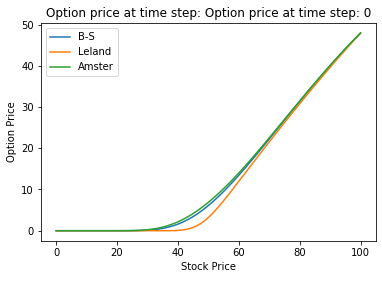

In [15]:
test3 = Implicit_Method(option, 100, .1, 101, 1001)
test3.run_BS()
test3.option_plot(0,"B-S", details=False)
test4 = Implicit_Method(option, 100, .1, 101, 1001)
test4.run_Leland(2.1,100)
test4.option_plot(0, "Leland", details=False)
test5 = Explicit_Method(option, 100, .1, 100, 1000)
test5.run_Amster(0.1,.25,50)
test5.option_plot(0, "Amster", details=False)
plt.show()

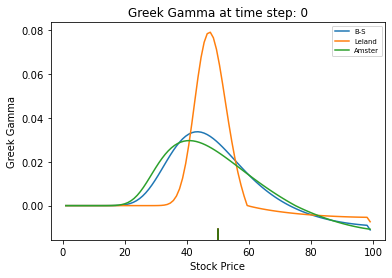

In [16]:
def gamma_plot(self,j, model, details=False):
    gamma = self.greek_gamma(self.grid[:,j],normalized = False) 
    S = np.linspace(0, self.Smax, num = self.M, endpoint=True)[1:-1]
    plt.plot(S,gamma,label=model)
    plt.legend()
    plt.xlabel('Stock Price')
    plt.ylabel('Greek Gamma')
    plt.title('Greek Gamma at time step: ' + str(j))
    if details == True: 
        plt.axvline(x=self.S0, ymin=-3,ymax=0.05, color = "red")
        plt.axvline(x=self.K, ymin=-3,ymax=0.05, color = "green")
        plt.legend(fontsize="x-small")

time = 0
gamma_plot(test3, time, "B-S")
gamma_plot(test4, time, "Leland")
gamma_plot(test5, time, "Amster", details=True)
plt.show()

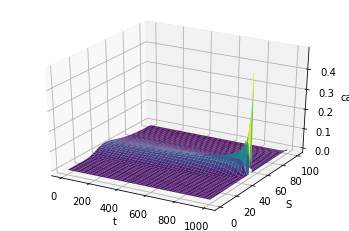

In [17]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def axis_3d(self):
    S = np.arange(1,self.M-1)
    t = np.arange(self.N)
    X, Y = np.meshgrid(t,S)
    Z = self.greek_gamma(self.grid[:,:],normalized = False) 
    return X,Y,Z

X,Y,Z = axis_3d(test3)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('call');


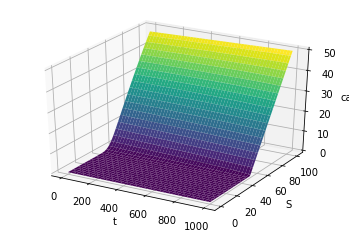

In [18]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def axis_3d(self):
    S = np.arange(self.M)
    t = np.arange(self.N)
    X, Y = np.meshgrid(t,S)
    Z = self.grid[:,:]
    return X,Y,Z

X,Y,Z = axis_3d(test4)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('S')
ax.set_zlabel('call');


#### Amster model revisited - Perturbational approach

Lets suppose $\mathcal{H}_0$ is the standard BS operator and $\psi_0(S,t)$ is the solution to the equation $\mathcal{H}_0\psi_0(S,t) = 0$. Now we are interested in finding the solution to $\mathcal{H}\psi=(\mathcal{H}_0+\lambda V)\psi=0$ where $V$ is some small perturbation to $\mathcal{H}_0$ controlled by $\lambda$. It is resonable to think that if $\psi(S,t)$ is the solution to $\mathcal{H}\psi=0$ then:
\begin{equation}
\psi=\psi_0+\lambda\psi_1+...\lambda^n\psi_n
\end{equation}

This is equivalent to:
\begin{equation}
\mathcal{H}\psi=\mathcal{H}_0\psi_0+\lambda(\mathcal{H}_0\psi_1+V\psi_0)+O(\lambda^2)
\end{equation}
For the Amster model $V\psi_0 = \lambda\sigma^2S^3 \left(\frac{\partial^2 \psi_0 }{\partial  S^2}\right)^2$
So now we turn our attention to the problem $(\mathcal{H}_0\psi_1+V\psi_0)=0$. This is an inhomogeneus BS equation where the term $V\psi_0$ is analitically known. We could try to find the solution analitically or numerically. 

